In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from pandas.tseries.offsets import BDay
from sklearn.metrics import mean_squared_error
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [3]:
df_main = pd.read_csv('TESLA.csv')
df_main.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [4]:
df_main.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1253,2021-08-09,710.169983,719.030029,705.130005,713.760010,713.760010,14715300
1254,2021-08-10,713.989990,716.590027,701.880005,709.989990,709.989990,13432300
1255,2021-08-11,712.710022,715.179993,704.210022,707.820007,707.820007,9800600
1256,2021-08-12,706.340027,722.799988,699.400024,722.250000,722.250000,17459100
1257,2021-08-13,723.710022,729.900024,714.340027,717.169983,717.169983,16698900


In [5]:
df_main.shape

(1258, 7)

In [6]:
time = pd.date_range(start='16/08/2016',periods=1258,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Date'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [7]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-08-16 to 2021-06-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [8]:
df_main.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df = df_main[['Close']]

In [10]:
df

,Close
time_stamp,
2016-08-16,44.722000
2016-08-17,44.647999
2016-08-18,44.702000
2016-08-19,45.000000
2016-08-22,44.585999
...,...
2021-06-04,713.760010
2021-06-07,709.989990
2021-06-08,707.820007


In [11]:
df.head()

,Close
time_stamp,
2016-08-16,44.722000
2016-08-17,44.647999
2016-08-18,44.702000
2016-08-19,45.000000
2016-08-22,44.585999


In [12]:
df.tail()

,Close
time_stamp,
2021-06-04,713.760010
2021-06-07,709.989990
2021-06-08,707.820007
2021-06-09,722.250000
2021-06-10,717.169983


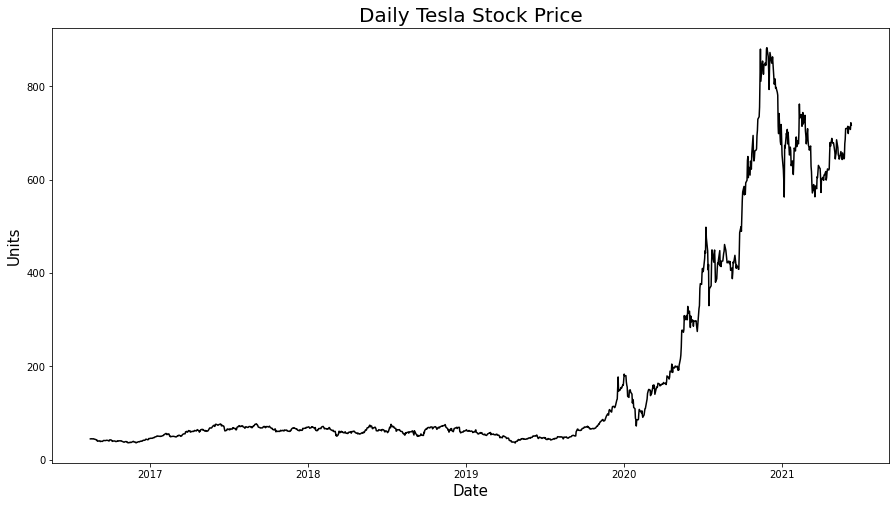

In [13]:
plt.plot(df,color='black')
plt.title('Daily Tesla Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
plt.rcParams['figure.figsize'] = [15,8]

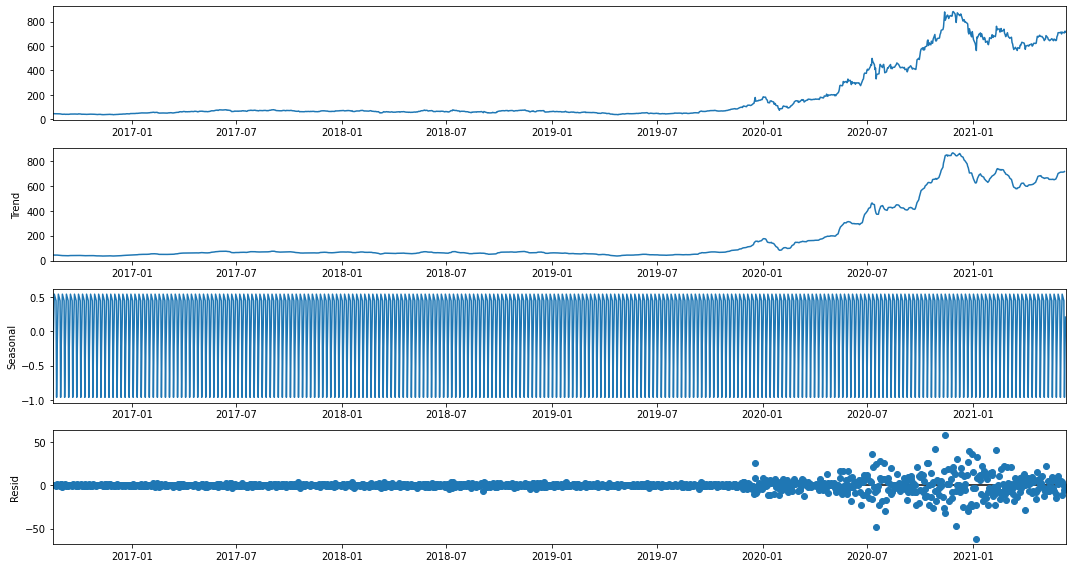

In [14]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

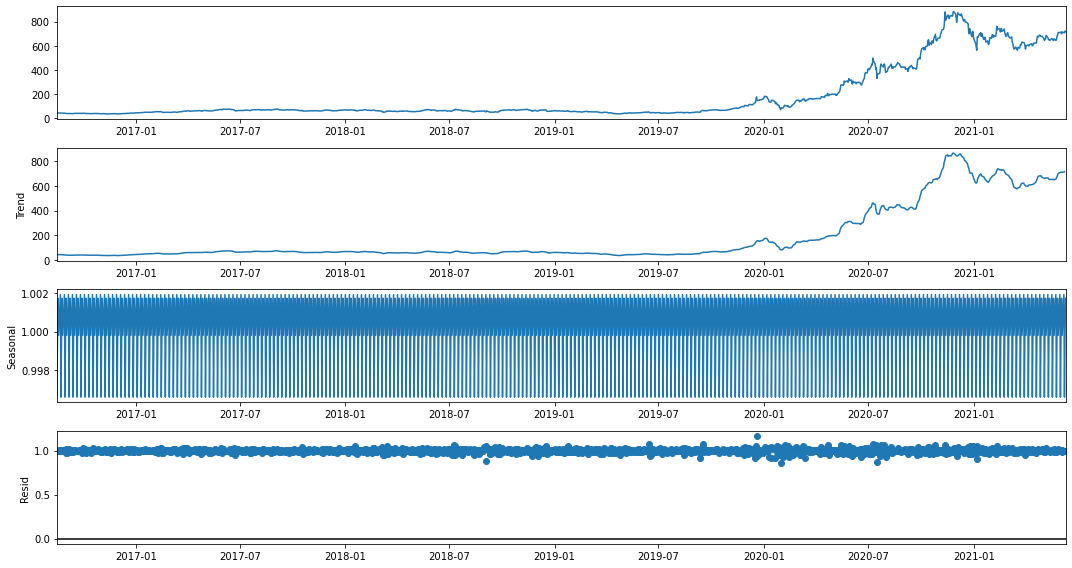

In [15]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

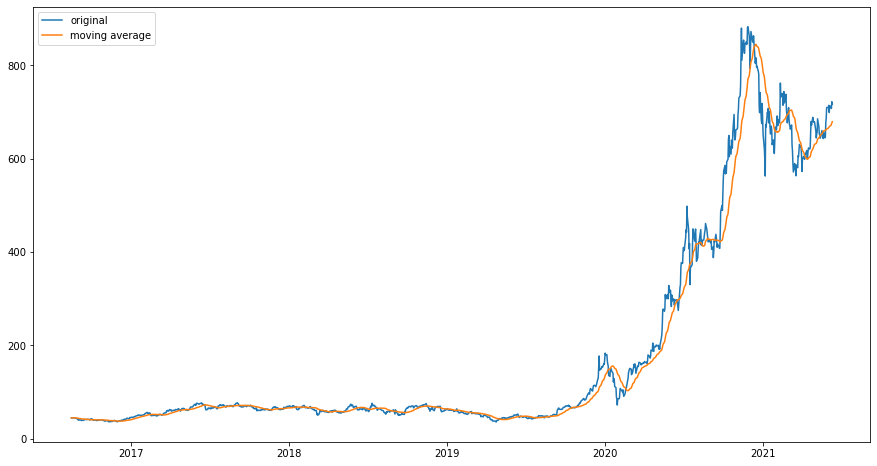

In [16]:
plt.plot(df,label='original')
plt.plot(df.rolling(25,min_periods=0).mean(),label='moving average')
plt.legend(loc='best')
plt.show()

In [35]:
# Model building - Exponential Smoothing Techniques

In [17]:
train = df.iloc[:1132]
test = df.iloc[1132:]

In [18]:
train.tail()

,Close
time_stamp,
2020-12-10,863.419983
2020-12-11,849.460022
2020-12-14,804.820007
2020-12-15,811.659973
2020-12-16,816.119995


In [19]:
test.head()

,Close
time_stamp,
2020-12-17,796.219971
2020-12-18,798.150024
2020-12-21,787.380005
2020-12-22,781.299988
2020-12-23,714.500000


In [20]:
len(train)

1132

In [21]:
len(test)

126

##### Simple Exponential Smoothing

In [22]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(optimized=True)
SES_model.summary()

Dep. Variable:,Close,No. Observations:,1132
Model:,SimpleExpSmoothing,SSE,94035.313
Optimized:,True,AIC,5007.083
Trend:,None,BIC,5017.146
Seasonal:,None,AICC,5007.118
Seasonal Periods:,None,Date:,"Fri, 25 Mar 2022"
Box-Cox:,False,Time:,15:16:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9792507,alpha,True
initial_level,44.720662,l.0,True


In [23]:
SES_predict = SES_model.forecast(len(test))

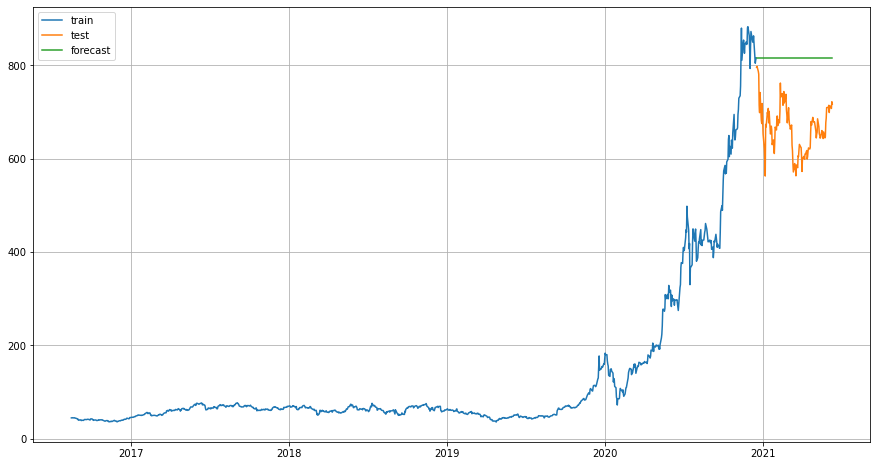

In [24]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [29]:
print("MAE:",MAE(test['Close'],SES_predict))
print("MAPE:",MAPE(test['Close'],SES_predict))

MAE: 151.1936399238193
MAPE: 23.449954115260045


##### Double Exponential Smoothing

In [30]:
DES = Holt(train,exponential=False,initialization_method='estimated')
DES_model = DES.fit(smoothing_level=0.9540377,
                   smoothing_trend=0.096887)
DES_model.summary()

Dep. Variable:,Close,No. Observations:,1132
Model:,Holt,SSE,96863.052
Optimized:,True,AIC,5044.621
Trend:,Additive,BIC,5064.748
Seasonal:,None,AICC,5044.696
Seasonal Periods:,None,Date:,"Fri, 25 Mar 2022"
Box-Cox:,False,Time:,15:17:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9540377,alpha,False
smoothing_trend,0.0968870,beta,False


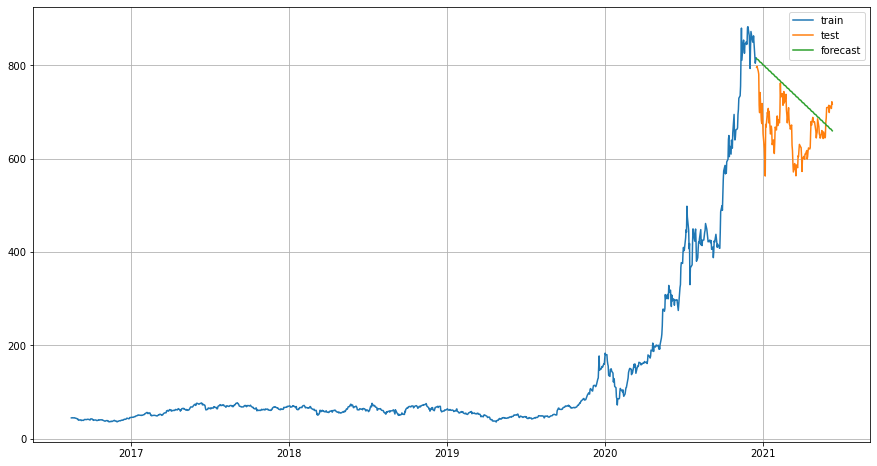

In [31]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [32]:
print("MAE:",MAE(test['Close'],DES_predict))
print("MAPE:",MAPE(test['Close'],DES_predict))

MAE: 80.01958573066459
MAPE: 12.50932830429543


##### Triple Exponential Smoothing

In [33]:
TES = ExponentialSmoothing(train,trend='additive',
                           seasonal='multiplicative',
                           initialization_method='estimated')
TES_model = TES.fit(smoothing_level=0.9540377,
                   smoothing_trend=0.096887,
                   smoothing_seasonal=2.0375e-02)
TES_model.summary()

Dep. Variable:,Close,No. Observations:,1132
Model:,ExponentialSmoothing,SSE,97610.843
Optimized:,True,AIC,5063.327
Trend:,Additive,BIC,5108.613
Seasonal:,Multiplicative,AICC,5063.563
Seasonal Periods:,5,Date:,"Fri, 25 Mar 2022"
Box-Cox:,False,Time:,15:18:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9540377,alpha,False
smoothing_trend,0.0968870,beta,False


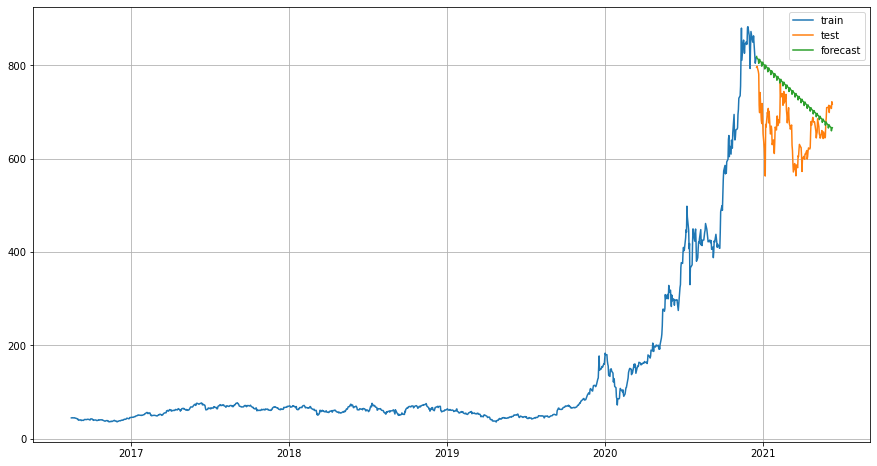

In [34]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [35]:
print("MAE:",MAE(test['Close'],TES_predict))
print("MAPE:",MAPE(test['Close'],TES_predict))

MAE: 81.15579469173726
MAPE: 12.687002470974976


##### ACF and PACF plots

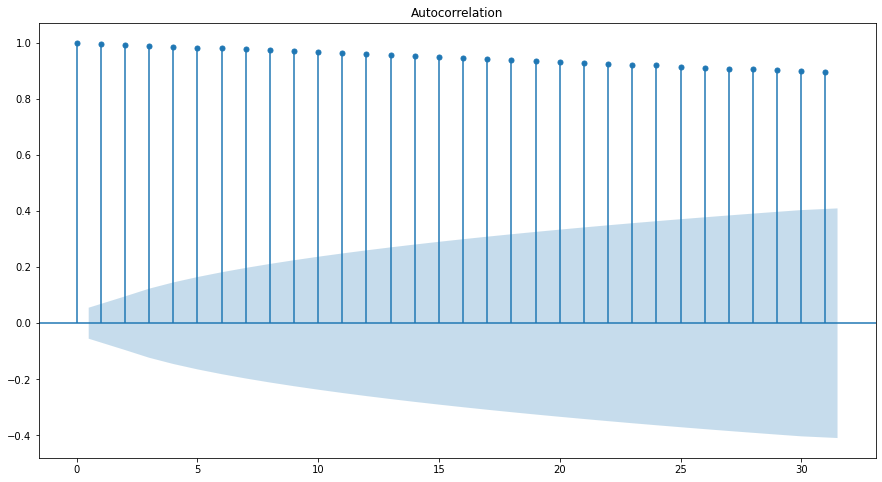

In [36]:
plot_acf(df)
plt.show()

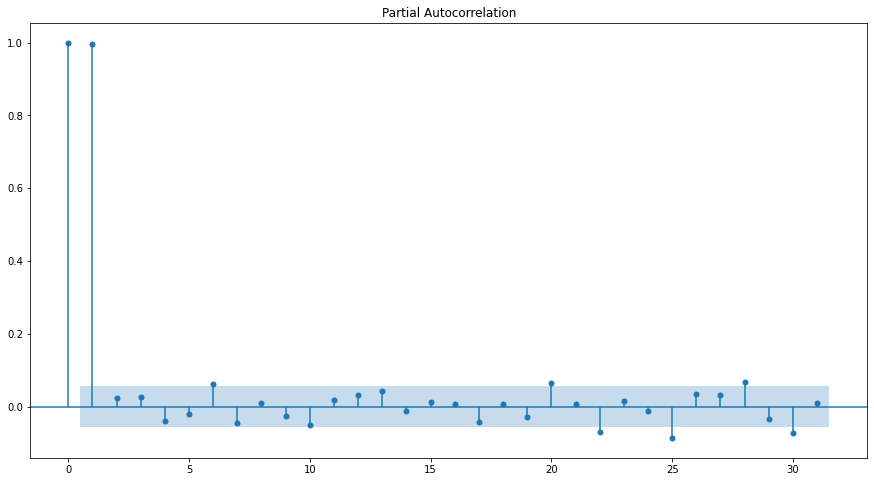

In [37]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [38]:
observations = df.values
df_results = adfuller(observations)
df_results

(0.3273256045634393,
 0.9785640149119201,
 21,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 9440.827811903462)

In [39]:
##### Non-stationary series -- proceed with ARIMA & SARIMA model

In [40]:
diff = df.diff(periods=1).dropna()
observations = diff.values
df_results = adfuller(observations)
df_results

(-6.121235451026588,
 8.845109817295882e-08,
 23,
 1233,
 {'1%': -3.4356646522289815,
  '5%': -2.863886926389418,
  '10%': -2.568019536239491},
 9417.482538587568)

##### ARIMA Model

In [41]:
import itertools

In [42]:
p = q = range(0,7)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
print("Parameter combinations are:")
for i in range(1,len(pdq)):
    print("ARIMA",pdq[i])

Parameter combinations are:
ARIMA (0, 1, 1)
ARIMA (0, 1, 2)
ARIMA (0, 1, 3)
ARIMA (0, 1, 4)
ARIMA (0, 1, 5)
ARIMA (0, 1, 6)
ARIMA (1, 1, 0)
ARIMA (1, 1, 1)
ARIMA (1, 1, 2)
ARIMA (1, 1, 3)
ARIMA (1, 1, 4)
ARIMA (1, 1, 5)
ARIMA (1, 1, 6)
ARIMA (2, 1, 0)
ARIMA (2, 1, 1)
ARIMA (2, 1, 2)
ARIMA (2, 1, 3)
ARIMA (2, 1, 4)
ARIMA (2, 1, 5)
ARIMA (2, 1, 6)
ARIMA (3, 1, 0)
ARIMA (3, 1, 1)
ARIMA (3, 1, 2)
ARIMA (3, 1, 3)
ARIMA (3, 1, 4)
ARIMA (3, 1, 5)
ARIMA (3, 1, 6)
ARIMA (4, 1, 0)
ARIMA (4, 1, 1)
ARIMA (4, 1, 2)
ARIMA (4, 1, 3)
ARIMA (4, 1, 4)
ARIMA (4, 1, 5)
ARIMA (4, 1, 6)
ARIMA (5, 1, 0)
ARIMA (5, 1, 1)
ARIMA (5, 1, 2)
ARIMA (5, 1, 3)
ARIMA (5, 1, 4)
ARIMA (5, 1, 5)
ARIMA (5, 1, 6)
ARIMA (6, 1, 0)
ARIMA (6, 1, 1)
ARIMA (6, 1, 2)
ARIMA (6, 1, 3)
ARIMA (6, 1, 4)
ARIMA (6, 1, 5)
ARIMA (6, 1, 6)


In [43]:
df_score_arima = pd.DataFrame(columns=['param','aic'])
df_score_arima

,param,aic


In [124]:
from warnings import filterwarnings
filterwarnings('ignore')

In [125]:
for param in pdq:
    try:
        model = ARIMA(train,order=param)
        arima_results = model.fit()
        print("ARIMA",param,"AIC:",arima_results.aic)
        df_score_arima = df_score_arima.append({'param':param,'aic':arima_results.aic},ignore_index=True)
    except:
        continue

ARIMA (0, 1, 0) AIC: 8207.41935075781
ARIMA (0, 1, 1) AIC: 8208.642498911167
ARIMA (0, 1, 2) AIC: 8209.623425930557
ARIMA (0, 1, 3) AIC: 8207.334566052814
ARIMA (0, 1, 4) AIC: 8204.48065016545
ARIMA (0, 1, 5) AIC: 8199.875089656674
ARIMA (0, 1, 6) AIC: 8194.585962013898
ARIMA (1, 1, 0) AIC: 8208.694682131216
ARIMA (1, 1, 1) AIC: 8210.456308137454
ARIMA (1, 1, 2) AIC: 8211.044250401472
ARIMA (1, 1, 3) AIC: 8207.931449653557
ARIMA (1, 1, 4) AIC: 8204.371498064567
ARIMA (1, 1, 5) AIC: 8198.365824972521
ARIMA (1, 1, 6) AIC: 8196.575284249788
ARIMA (2, 1, 0) AIC: 8209.273264994566
ARIMA (2, 1, 1) AIC: 8210.665384211212
ARIMA (2, 1, 2) AIC: 8149.413300949462
ARIMA (2, 1, 3) AIC: 8195.202244470174
ARIMA (2, 1, 5) AIC: 8191.109923130445
ARIMA (2, 1, 6) AIC: 8180.73334959734
ARIMA (3, 1, 0) AIC: 8207.9838163383
ARIMA (3, 1, 1) AIC: 8208.147446325504
ARIMA (3, 1, 2) AIC: 8150.778405185703
ARIMA (3, 1, 3) AIC: 8196.371473114858
ARIMA (3, 1, 4) AIC: 8152.217473675939
ARIMA (3, 1, 6) AIC: 8183.3791

In [126]:
df_score_arima.sort_values('aic')

,param,aic
38,"(6, 1, 6)",8105.754630
33,"(5, 1, 3)",8148.206191
16,"(2, 1, 2)",8149.413301
22,"(3, 1, 2)",8150.778405
29,"(4, 1, 3)",8151.314425
24,"(3, 1, 4)",8152.217474
36,"(6, 1, 2)",8177.655844
37,"(6, 1, 3)",8179.795743
19,"(2, 1, 6)",8180.733350
25,"(3, 1, 6)",8183.379166


In [116]:
arima_model = ARIMA(train,(6,1,6))
arima_results = arima_model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -4038.877
Method:                       css-mle   S.D. of innovations              8.436
Date:                Fri, 25 Mar 2022   AIC                           8105.755
Time:                        15:43:56   BIC                           8176.187
Sample:                    08-17-2016   HQIC                          8132.363
                         - 12-16-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5272    1.5e-05   3.51e+04      0.000       0.527       0.527
ar.L1.D.Close    -0.0907   3.74e-06  -2.43e+04      0.000      -0.091      -0.091
ar.L2.D.Close    -0.0055        nan     

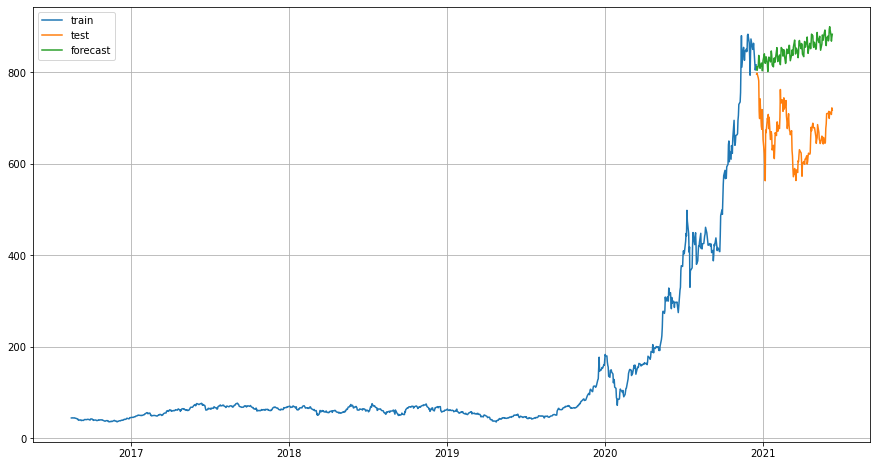

In [117]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [118]:
print("MAE:",MAE(test['Close'],forecasted_values_arima))
print("MAPE:",MAPE(test['Close'],forecasted_values_arima))

MAE: 183.06340265619085
MAPE: 28.31335772148462


##### SARIMA Model

In [163]:
p = q = range(0,6)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
pdq_seasonal = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]

df_score = pd.DataFrame(columns=['param','seasonal','aic'])
df_score

,param,seasonal,aic


In [164]:
for param in pdq:
    for seasonal_param in pdq_seasonal:
        model = SARIMAX(train,
                       order = param,
                       seasonal_order = seasonal_param,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        sarimax_results = model.fit()
        print("SARIMAX",param,seasonal_param,'AIC:',sarimax_results.aic)
        df_score = df_score.append({'param':param,'seasonal':seasonal_param,'aic':sarimax_results.aic},ignore_index=True)

SARIMAX (0, 1, 0) (0, 1, 0, 6) AIC: 9000.815089686253
SARIMAX (0, 1, 0) (0, 1, 1, 6) AIC: 8143.915571833584
SARIMAX (0, 1, 0) (0, 1, 2, 6) AIC: 8099.241873437708
SARIMAX (0, 1, 0) (0, 1, 3, 6) AIC: 8062.85265547491
SARIMAX (0, 1, 0) (0, 1, 4, 6) AIC: 8021.982927299665
SARIMAX (0, 1, 0) (0, 1, 5, 6) AIC: 7983.002213661324
SARIMAX (0, 1, 0) (1, 1, 0, 6) AIC: 8593.756241021414
SARIMAX (0, 1, 0) (1, 1, 1, 6) AIC: 8140.472245420735
SARIMAX (0, 1, 0) (1, 1, 2, 6) AIC: 8101.026550936143
SARIMAX (0, 1, 0) (1, 1, 3, 6) AIC: 8064.001329811497
SARIMAX (0, 1, 0) (1, 1, 4, 6) AIC: 8021.332435744538
SARIMAX (0, 1, 0) (1, 1, 5, 6) AIC: 7984.750316830066
SARIMAX (0, 1, 0) (2, 1, 0, 6) AIC: 8437.607611439773
SARIMAX (0, 1, 0) (2, 1, 1, 6) AIC: 8107.814881181125
SARIMAX (0, 1, 0) (2, 1, 2, 6) AIC: 8102.94100351532
SARIMAX (0, 1, 0) (2, 1, 3, 6) AIC: 8064.216668997776
SARIMAX (0, 1, 0) (2, 1, 4, 6) AIC: 8014.720923173918
SARIMAX (0, 1, 0) (2, 1, 5, 6) AIC: 7977.936588157516
SARIMAX (0, 1, 0) (3, 1, 0, 6)

SARIMAX (0, 1, 4) (1, 1, 2, 6) AIC: 8073.202209404795
SARIMAX (0, 1, 4) (1, 1, 3, 6) AIC: 8036.130445938883
SARIMAX (0, 1, 4) (1, 1, 4, 6) AIC: 7996.452020010773
SARIMAX (0, 1, 4) (1, 1, 5, 6) AIC: 7960.4999166574
SARIMAX (0, 1, 4) (2, 1, 0, 6) AIC: 8425.463669095583
SARIMAX (0, 1, 4) (2, 1, 1, 6) AIC: 8104.899009398676
SARIMAX (0, 1, 4) (2, 1, 2, 6) AIC: 8074.599540006969
SARIMAX (0, 1, 4) (2, 1, 3, 6) AIC: 8038.598376486022
SARIMAX (0, 1, 4) (2, 1, 4, 6) AIC: 7990.70129053735
SARIMAX (0, 1, 4) (2, 1, 5, 6) AIC: 7951.979360611187
SARIMAX (0, 1, 4) (3, 1, 0, 6) AIC: 8273.085927094166
SARIMAX (0, 1, 4) (3, 1, 1, 6) AIC: 8067.337736152295
SARIMAX (0, 1, 4) (3, 1, 2, 6) AIC: 8067.350596844821
SARIMAX (0, 1, 4) (3, 1, 3, 6) AIC: 8029.896894200589
SARIMAX (0, 1, 4) (3, 1, 4, 6) AIC: 7992.696873597966
SARIMAX (0, 1, 4) (3, 1, 5, 6) AIC: 7951.924429103841
SARIMAX (0, 1, 4) (4, 1, 0, 6) AIC: 8162.368535607455
SARIMAX (0, 1, 4) (4, 1, 1, 6) AIC: 8027.901403458853
SARIMAX (0, 1, 4) (4, 1, 2, 6) 

SARIMAX (1, 1, 2) (2, 1, 4, 6) AIC: 8006.525142598734
SARIMAX (1, 1, 2) (2, 1, 5, 6) AIC: 7968.4740596976335
SARIMAX (1, 1, 2) (3, 1, 0, 6) AIC: 8272.101550709867
SARIMAX (1, 1, 2) (3, 1, 1, 6) AIC: 8063.611457333799
SARIMAX (1, 1, 2) (3, 1, 2, 6) AIC: 8063.890227022034
SARIMAX (1, 1, 2) (3, 1, 3, 6) AIC: 8046.856314401793
SARIMAX (1, 1, 2) (3, 1, 4, 6) AIC: 8008.523351155085
SARIMAX (1, 1, 2) (3, 1, 5, 6) AIC: 7967.879130066365
SARIMAX (1, 1, 2) (4, 1, 0, 6) AIC: 8158.164704043214
SARIMAX (1, 1, 2) (4, 1, 1, 6) AIC: 8024.71020454296
SARIMAX (1, 1, 2) (4, 1, 2, 6) AIC: 8025.985717504581
SARIMAX (1, 1, 2) (4, 1, 3, 6) AIC: 8019.726493707965
SARIMAX (1, 1, 2) (4, 1, 4, 6) AIC: 8007.757669029504
SARIMAX (1, 1, 2) (4, 1, 5, 6) AIC: 7939.117902284095
SARIMAX (1, 1, 2) (5, 1, 0, 6) AIC: 8108.2459988626
SARIMAX (1, 1, 2) (5, 1, 1, 6) AIC: 7988.327949349921
SARIMAX (1, 1, 2) (5, 1, 2, 6) AIC: 7983.894567315042
SARIMAX (1, 1, 2) (5, 1, 3, 6) AIC: 7981.739509672448
SARIMAX (1, 1, 2) (5, 1, 4, 6)

SARIMAX (2, 1, 0) (4, 1, 0, 6) AIC: 8149.974825788187
SARIMAX (2, 1, 0) (4, 1, 1, 6) AIC: 8016.572540104769
SARIMAX (2, 1, 0) (4, 1, 2, 6) AIC: 8017.733425530427
SARIMAX (2, 1, 0) (4, 1, 3, 6) AIC: 8011.353447195832
SARIMAX (2, 1, 0) (4, 1, 4, 6) AIC: 8012.7861781401225
SARIMAX (2, 1, 0) (4, 1, 5, 6) AIC: 7963.450075403629
SARIMAX (2, 1, 0) (5, 1, 0, 6) AIC: 8100.073758101966
SARIMAX (2, 1, 0) (5, 1, 1, 6) AIC: 7980.9187580383705
SARIMAX (2, 1, 0) (5, 1, 2, 6) AIC: 7975.6277272950265
SARIMAX (2, 1, 0) (5, 1, 3, 6) AIC: 7973.447409398406
SARIMAX (2, 1, 0) (5, 1, 4, 6) AIC: 7974.90998835412
SARIMAX (2, 1, 0) (5, 1, 5, 6) AIC: 7951.905269186494
SARIMAX (2, 1, 1) (0, 1, 0, 6) AIC: 8882.355088819697
SARIMAX (2, 1, 1) (0, 1, 1, 6) AIC: 8140.373300630892
SARIMAX (2, 1, 1) (0, 1, 2, 6) AIC: 8095.149803381128
SARIMAX (2, 1, 1) (0, 1, 3, 6) AIC: 8058.6553828625765
SARIMAX (2, 1, 1) (0, 1, 4, 6) AIC: 8017.914680505346
SARIMAX (2, 1, 1) (0, 1, 5, 6) AIC: 7981.50398362864
SARIMAX (2, 1, 1) (1, 1, 0

KeyboardInterrupt: 

In [165]:
df_score.sort_values('aic')

,param,seasonal,aic
509,"(2, 1, 2)","(0, 1, 5, 6)",7904.925602
215,"(0, 1, 5)","(5, 1, 5, 6)",7922.841864
514,"(2, 1, 2)","(1, 1, 4, 6)",7929.693079
389,"(1, 1, 4)","(4, 1, 5, 6)",7929.920221
137,"(0, 1, 3)","(4, 1, 5, 6)",7930.004844
...,...,...,...
72,"(0, 1, 2)","(0, 1, 0, 6)",8981.303840
432,"(2, 1, 0)","(0, 1, 0, 6)",8988.281304
36,"(0, 1, 1)","(0, 1, 0, 6)",8995.765505
0,"(0, 1, 0)","(0, 1, 0, 6)",9000.815090


In [217]:
model = SARIMAX(train,
                       order = (10,1,3),
                       seasonal_order = (0,1,6,6),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [218]:
print(sarimax_results.summary())

                                              SARIMAX Results                                              
Dep. Variable:                                               Close   No. Observations:                 1132
Model:             SARIMAX(10, 1, 3)x(0, 1, [1, 2, 3, 4, 5, 6], 6)   Log Likelihood               -3905.878
Date:                                             Fri, 25 Mar 2022   AIC                           7851.757
Time:                                                     16:11:23   BIC                           7951.544
Sample:                                                 08-16-2016   HQIC                          7889.532
                                                      - 12-16-2020                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [219]:
forecast = sarimax_results.forecast(len(test))

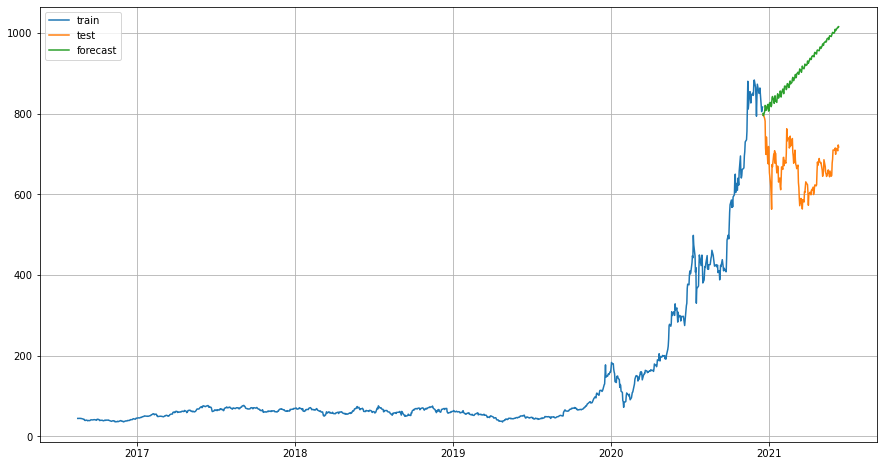

In [220]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [221]:
print(mean_squared_error(test,forecast,squared=False))
print(MAPE(test['Close'],forecast))

258.53644788681953
37.49370812960108


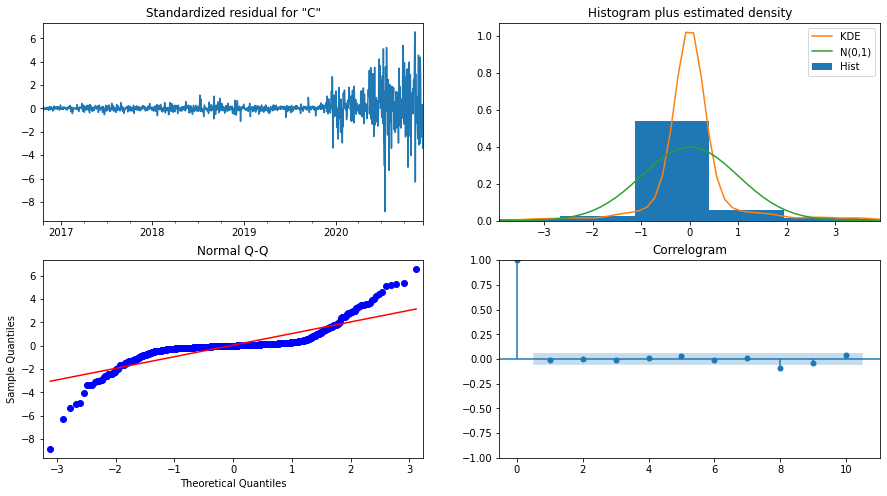

In [222]:
sarimax_results.plot_diagnostics();

# ARCH/GARCH Model

In [14]:
df

,Close
time_stamp,
2016-08-16,44.722000
2016-08-17,44.647999
2016-08-18,44.702000
2016-08-19,45.000000
2016-08-22,44.585999
...,...
2021-06-04,713.760010
2021-06-07,709.989990
2021-06-08,707.820007


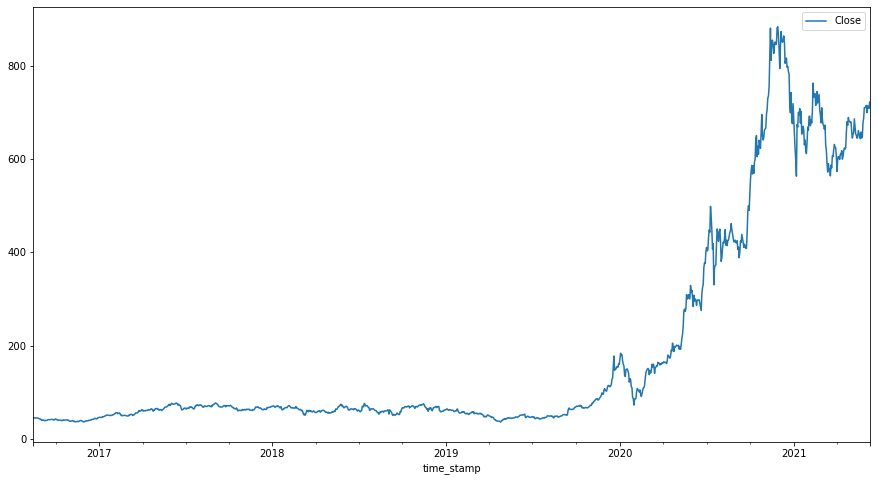

In [15]:
df.plot()
plt.show()

In [16]:
DES = Holt(df,exponential=False,initialization_method='estimated')
DES_model = DES.fit(smoothing_level=0.9540377,
                   smoothing_trend=0.096887)
DES_model.summary()

Dep. Variable:,Close,No. Observations:,1258
Model:,Holt,SSE,166054.431
Optimized:,True,AIC,6150.553
Trend:,Additive,BIC,6171.102
Seasonal:,None,AICC,6150.620
Seasonal Periods:,None,Date:,"Sat, 26 Mar 2022"
Box-Cox:,False,Time:,07:40:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9540377,alpha,False
smoothing_trend,0.0968870,beta,False


In [17]:
resid = DES_model.resid

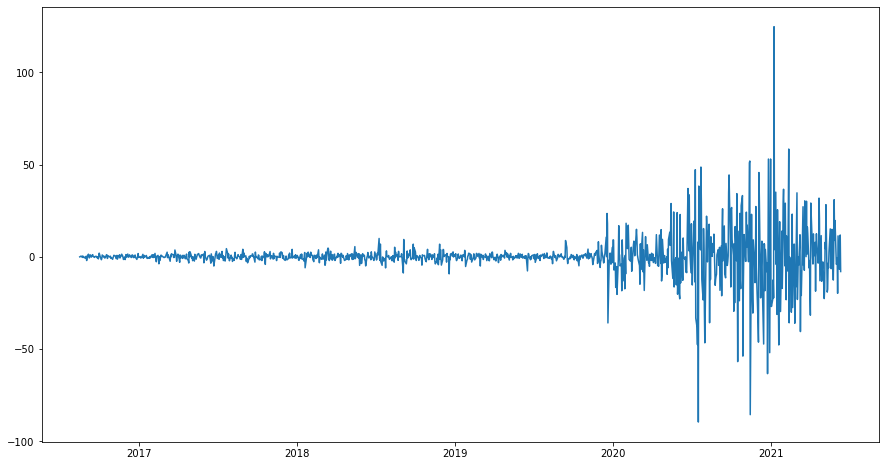

In [18]:
plt.plot(resid)
plt.show()

In [19]:
resid_df = pd.DataFrame(resid,columns=['residuals'])

In [20]:
resid_df.shape

(1258, 1)

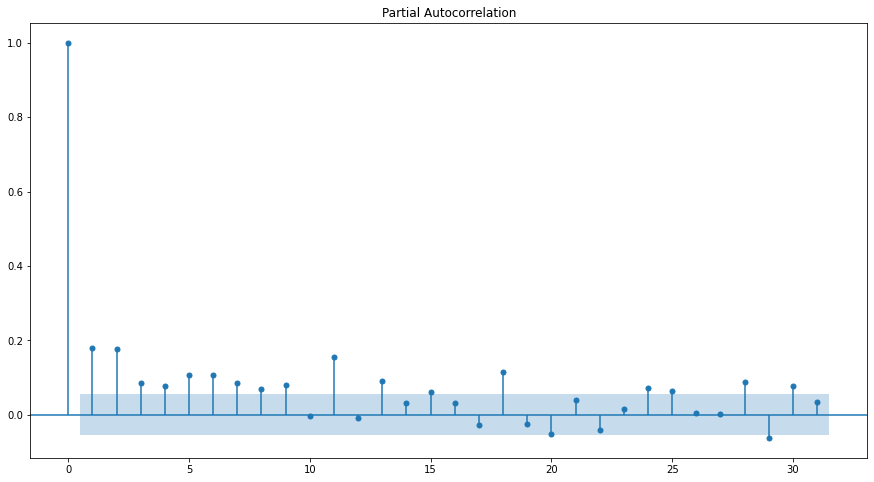

In [21]:
plot_pacf(resid_df**2)
plt.show()

##### ARCH - 1 Model

In [398]:
model_1 = arch_model(resid_df,p=1,q=0)
model_fit_1 = model_1.fit(disp='off')
model_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4449.94
Distribution:                  Normal   AIC:                           8905.88
Method:            Maximum Likelihood   BIC:                           8921.29
                                        No. Observations:                 1258
Date:                Fri, Mar 25 2022   Df Residuals:                     1257
Time:                        20:30:46   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1631      0.279      0.584      0.559 [ -0.384,  0.710]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         35.3985     10.789      3.281  1.035e-03 [ 14.252, 56.545]
alpha[1]       1.0000      0.284      3.517  4.361e-04 [  0.443,  1.557]
========================================================================

Covariance estimator: robust
"""

In [399]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=1, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [400]:
rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

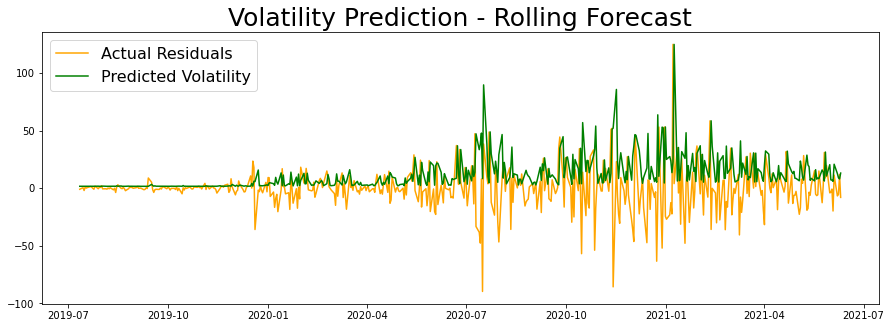

In [401]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (1,1) Model

In [395]:
model_2 = arch_model(resid_df,p=1,q=1)
model_fit_2 = model_2.fit(disp='off')
model_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3395.18
Distribution:                  Normal   AIC:                           6798.37
Method:            Maximum Likelihood   BIC:                           6818.91
                                        No. Observations:                 1258
Date:                Fri, Mar 25 2022   Df Residuals:                     1257
Time:                        20:30:05   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0227  5.449e-02      0.416      0.677 [-8.413e-02,  0.129]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0424  3.249e-02      1.304      0.192 [-2.131e-02,  0.106]
alpha[1]       0.0695  2.162e-02      3.213  1.313e-03  [2.710e-02,  0.112]
beta[1]        0.9305  2.444e-02     38.068      0.000    [  0.883,  0.978]
===========================================================================

Covariance estimator: robust
"""

In [396]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


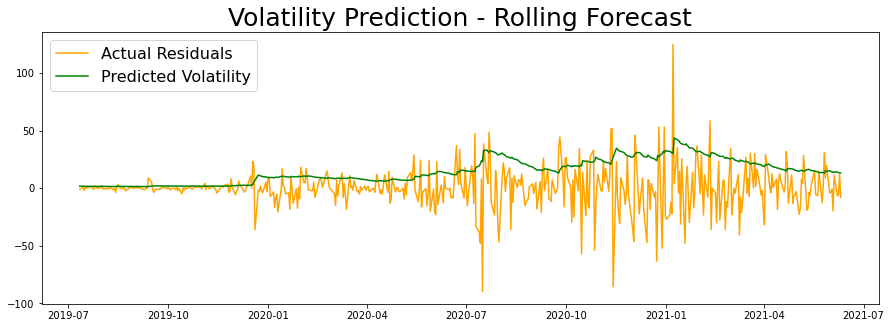

In [397]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 2 Model

In [389]:
model_3 = arch_model(resid_df,p=2,q=0)
model_fit_3 = model_3.fit(disp='off')
model_fit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3866.68
Distribution:                  Normal   AIC:                           7741.37
Method:            Maximum Likelihood   BIC:                           7761.91
                                        No. Observations:                 1258
Date:                Fri, Mar 25 2022   Df Residuals:                     1257
Time:                        20:23:15   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3455      0.147      2.352  1.868e-02 [5.758e-02,  0.633]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.7179      1.000      3.720  1.996e-04 [  1.759,  5.677]
alpha[1]       0.4254  7.233e-02      5.882  4.047e-09 [  0.284,  0.567]
alpha[2]       0.5746  9.922e-02      5.791  7.013e-09 [  0.380,  0.769]
========================================================================

Covariance estimator: robust
"""

In [391]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=2, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

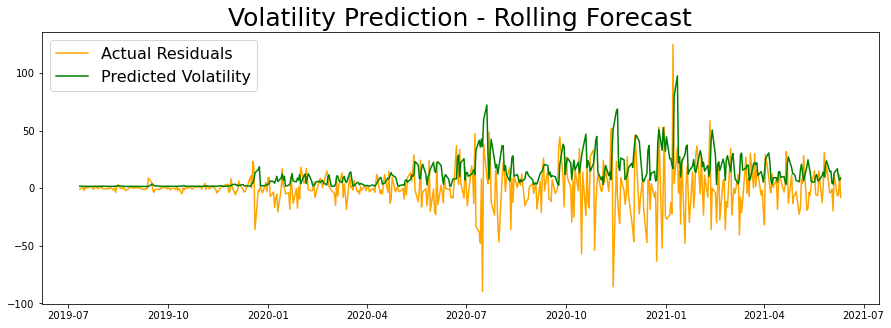

In [394]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (1,2) Model

In [23]:
model_4 = arch_model(resid_df,p=1,q=2)
model_fit_4 = model_4.fit(disp='off')
model_fit_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3394.95
Distribution:                  Normal   AIC:                           6799.89
Method:            Maximum Likelihood   BIC:                           6825.58
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        07:42:25   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0230  5.459e-02      0.421      0.673 [-8.399e-02,  0.130]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0463  3.699e-02      1.251      0.211 [-2.623e-02,  0.119]
alpha[1]       0.0760  2.280e-02      3.332  8.623e-04  [3.128e-02,  0.121]
beta[1]        0.8198      0.177      4.625  3.753e-06    [  0.472,  1.167]
beta[2]        0.1043      0.166      0.628      0.530    [ -0.221,  0.430]
===========================================================================

Covariance estimator: robust
"""

In [24]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=1, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

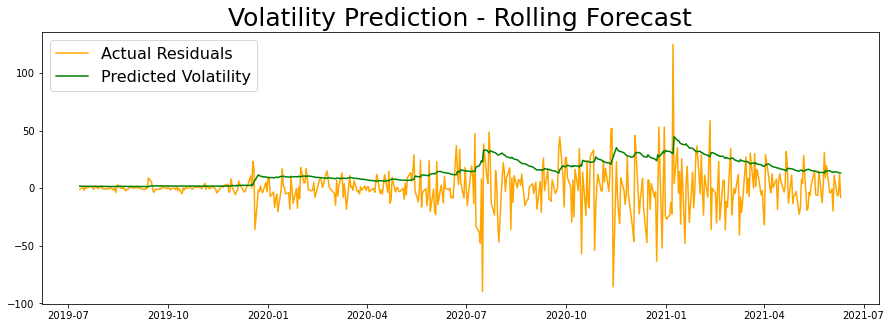

In [25]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (2,1) Model

In [26]:
model_5 = arch_model(resid_df,p=2,q=1)
model_fit_5 = model_5.fit(disp='off')
model_fit_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3395.18
Distribution:                  Normal   AIC:                           6800.37
Method:            Maximum Likelihood   BIC:                           6826.05
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        07:47:44   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0227  5.449e-02      0.416      0.677 [-8.412e-02,  0.129]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0424  3.510e-02      1.207      0.227   [-2.643e-02,  0.111]
alpha[1]       0.0695  2.906e-02      2.391  1.681e-02    [1.252e-02,  0.126]
alpha[2]   1.8452e-08  4.057e-02  4.548e-07      1.000 [-7.952e-02,7.952e-02]
beta[1]        0.9305  2.988e-02     31.137 7.580e-213      [  0.872,  0.989]
=============================================================================

Covariance estimator: robust
"""

In [27]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=2, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


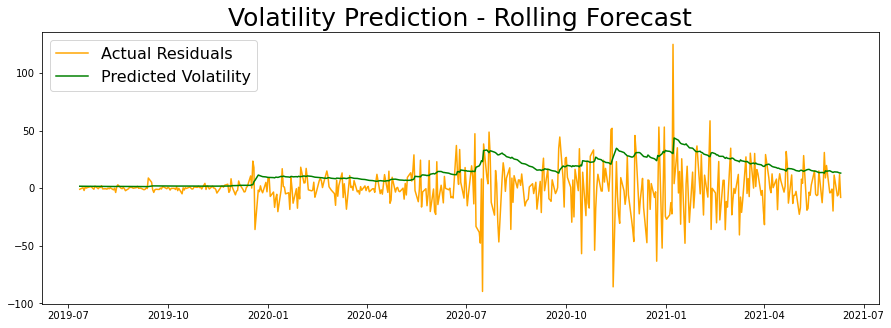

In [28]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (2,2) Model

In [29]:
model_6 = arch_model(resid_df,p=2,q=2)
model_fit_6 = model_6.fit(disp='off')
model_fit_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3394.86
Distribution:                  Normal   AIC:                           6801.71
Method:            Maximum Likelihood   BIC:                           6832.54
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        08:00:02   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0213  5.475e-02      0.389      0.698 [-8.604e-02,  0.129]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0750  6.853e-02      1.094      0.274 [-5.933e-02,  0.209]
alpha[1]       0.0578  2.378e-02      2.432  1.502e-02  [1.122e-02,  0.104]
alpha[2]       0.0661  4.190e-02      1.579      0.114 [-1.598e-02,  0.148]
beta[1]        0.1688      0.231      0.731      0.465    [ -0.284,  0.622]
beta[2]        0.7072      0.196      3.616  2.989e-04    [  0.324,  1.091]
===========================================================================

Covariance estimator: robust
"""

In [30]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


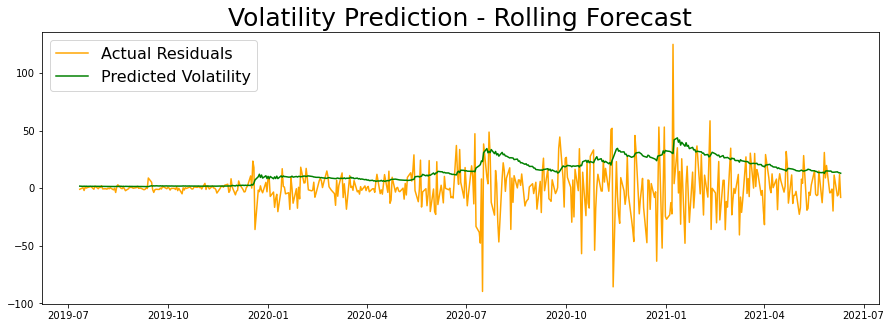

In [31]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 3 Model

In [32]:
model_7 = arch_model(resid_df,p=3,q=0)
model_fit_7 = model_7.fit(disp='off')
model_fit_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3663.67
Distribution:                  Normal   AIC:                           7337.34
Method:            Maximum Likelihood   BIC:                           7363.03
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        08:02:33   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1798  8.924e-02      2.015  4.393e-02 [4.890e-03,  0.355]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.1463      0.391      5.496  3.891e-08 [  1.381,  2.912]
alpha[1]       0.2485  5.437e-02      4.571  4.849e-06 [  0.142,  0.355]
alpha[2]       0.3900      0.105      3.717  2.020e-04 [  0.184,  0.596]
alpha[3]       0.3615  8.767e-02      4.123  3.740e-05 [  0.190,  0.533]
========================================================================

Covariance estimator: robust
"""

In [33]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

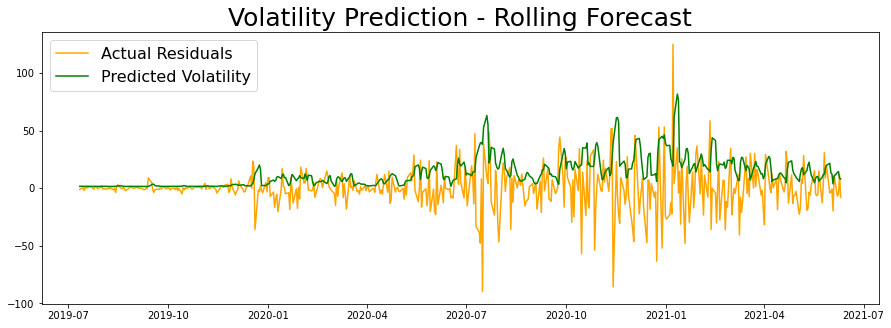

In [34]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (3,1) Model

In [35]:
model_8 = arch_model(resid_df,p=3,q=1)
model_fit_8 = model_8.fit(disp='off')
model_fit_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3395.18
Distribution:                  Normal   AIC:                           6802.37
Method:            Maximum Likelihood   BIC:                           6833.19
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        08:05:29   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0227  5.484e-02      0.413      0.679 [-8.482e-02,  0.130]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0424  4.574e-02      0.926      0.354   [-4.728e-02,  0.132]
alpha[1]       0.0695  2.930e-02      2.371  1.773e-02    [1.205e-02,  0.127]
alpha[2]   1.3648e-08  4.930e-02  2.769e-07      1.000 [-9.662e-02,9.662e-02]
alpha[3]   8.5112e-09  5.541e-02  1.536e-07      1.000      [ -0.109,  0.109]
beta[1]        0.9305  4.465e-02     20.841  1.838e-96      [  0.843,  1.018]
=============================================================================

Covariance estimator: robust
"""

In [36]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=3, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\python\lib\site-pac

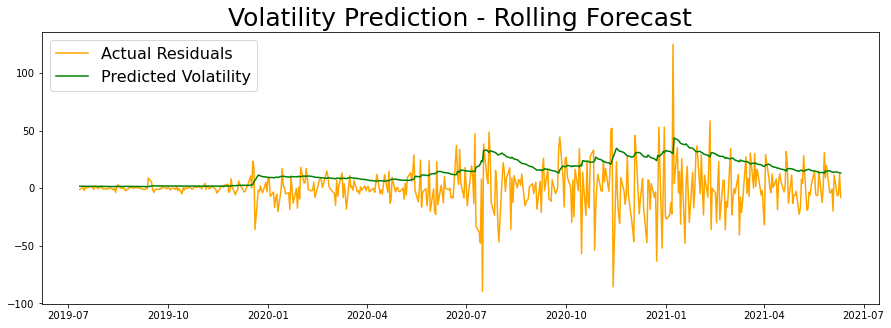

In [37]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (1,3) Model

In [41]:
model_9 = arch_model(resid_df,p=1,q=3)
model_fit_9 = model_9.fit(disp='off')
model_fit_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3392.91
Distribution:                  Normal   AIC:                           6797.83
Method:            Maximum Likelihood   BIC:                           6828.65
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        10:12:34   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0234  5.501e-02      0.426      0.670 [-8.439e-02,  0.131]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0557  4.311e-02      1.293      0.196 [-2.877e-02,  0.140]
alpha[1]       0.0921  2.676e-02      3.443  5.755e-04  [3.969e-02,  0.145]
beta[1]        0.7115      0.398      1.790  7.350e-02 [-6.769e-02,  1.491]
beta[2]    5.1187e-11      0.807  6.344e-11      1.000    [ -1.581,  1.581]
beta[3]        0.1964      0.419      0.468      0.639    [ -0.625,  1.018]
===========================================================================

Covariance estimator: robust
"""

In [47]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=1, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

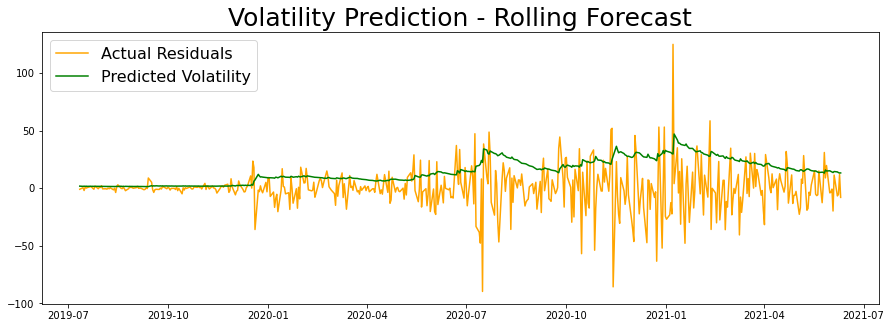

In [48]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (3,2) Model

In [43]:
model_10 = arch_model(resid_df,p=3,q=2)
model_fit_10 = model_10.fit(disp='off')
model_fit_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3394.81
Distribution:                  Normal   AIC:                           6803.62
Method:            Maximum Likelihood   BIC:                           6839.58
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        10:13:18   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0235  5.449e-02      0.432      0.666 [-8.326e-02,  0.130]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0804  6.645e-02      1.210      0.226   [-4.982e-02,  0.211]
alpha[1]       0.0604  2.570e-02      2.351  1.873e-02    [1.005e-02,  0.111]
alpha[2]       0.0734  3.049e-02      2.408  1.603e-02    [1.367e-02,  0.133]
alpha[3]       0.0000  3.787e-02      0.000      1.000 [-7.423e-02,7.423e-02]
beta[1]        0.0000  4.570e-02      0.000      1.000 [-8.956e-02,8.956e-02]
beta[2]        0.8662  5.123e-02     16.906  4.033e-64      [  0.766,  0.967]
=============================================================================

Covariance estimator: robust
"""

In [39]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=3, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


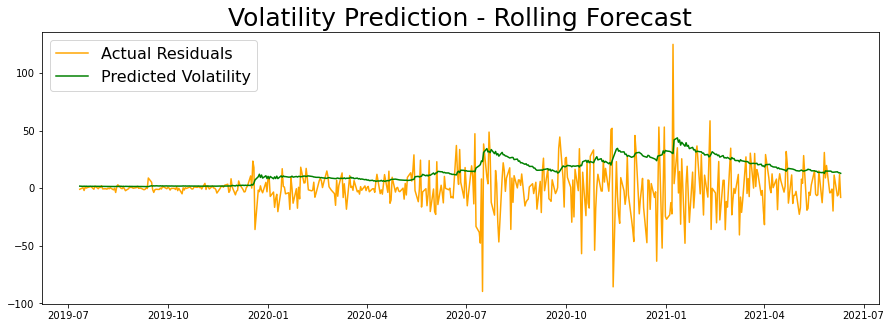

In [40]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (2,3) Model

In [45]:
model_11 = arch_model(resid_df,p=2,q=3)
model_fit_11 = model_11.fit(disp='off')
model_fit_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3390.44
Distribution:                  Normal   AIC:                           6794.87
Method:            Maximum Likelihood   BIC:                           6830.83
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        10:14:02   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0205  5.350e-02      0.383      0.702 [-8.438e-02,  0.125]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0840  6.120e-02      1.372      0.170 [-3.597e-02,  0.204]
alpha[1]       0.0598  2.629e-02      2.275  2.291e-02  [8.282e-03,  0.111]
alpha[2]       0.0826  3.537e-02      2.335  1.953e-02  [1.328e-02,  0.152]
beta[1]        0.2969      0.142      2.096  3.609e-02  [1.925e-02,  0.575]
beta[2]    3.2698e-11      0.253  1.292e-10      1.000    [ -0.496,  0.496]
beta[3]        0.5607      0.159      3.531  4.144e-04    [  0.249,  0.872]
===========================================================================

Covariance estimator: robust
"""

In [49]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=2, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

C:\Users\python\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


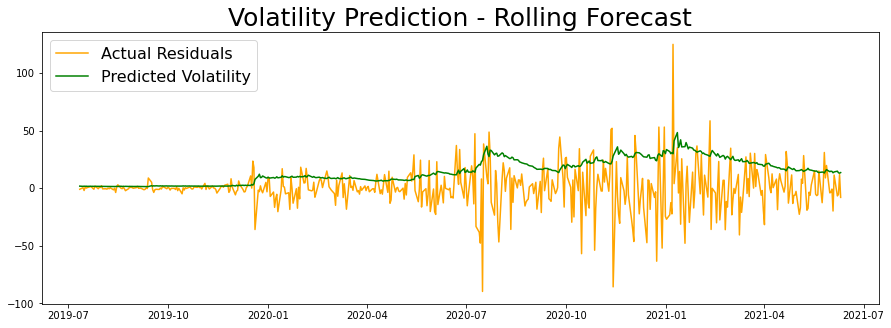

In [50]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### GARCH (3,3) Model

In [51]:
model_12 = arch_model(resid_df,p=3,q=3)
model_fit_12 = model_12.fit(disp='off')
model_fit_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3390.44
Distribution:                  Normal   AIC:                           6796.87
Method:            Maximum Likelihood   BIC:                           6837.97
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        10:18:42   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0205  5.366e-02      0.382      0.702 [-8.466e-02,  0.126]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0840  9.009e-02      0.932      0.351 [-9.260e-02,  0.261]
alpha[1]       0.0598  2.743e-02      2.181  2.921e-02  [6.054e-03,  0.114]
alpha[2]       0.0826  3.492e-02      2.365  1.802e-02  [1.415e-02,  0.151]
alpha[3]       0.0000  7.858e-02      0.000      1.000    [ -0.154,  0.154]
beta[1]        0.2969      0.415      0.716      0.474    [ -0.516,  1.109]
beta[2]    7.0249e-12      0.243  2.890e-11      1.000    [ -0.476,  0.476]
beta[3]        0.5607      0.195      2.876  4.025e-03    [  0.179,  0.943]
===========================================================================

Covariance estimator: robust
"""

In [52]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=3, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

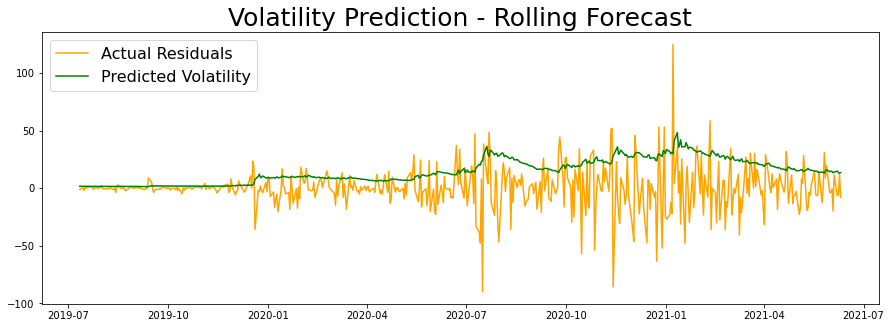

In [53]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 3 Model

In [54]:
model_13 = arch_model(resid_df,p=3,q=0)
model_fit_13 = model_13.fit(disp='off')
model_fit_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3663.67
Distribution:                  Normal   AIC:                           7337.34
Method:            Maximum Likelihood   BIC:                           7363.03
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        10:35:22   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1798  8.924e-02      2.015  4.393e-02 [4.890e-03,  0.355]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.1463      0.391      5.496  3.891e-08 [  1.381,  2.912]
alpha[1]       0.2485  5.437e-02      4.571  4.849e-06 [  0.142,  0.355]
alpha[2]       0.3900      0.105      3.717  2.020e-04 [  0.184,  0.596]
alpha[3]       0.3615  8.767e-02      4.123  3.740e-05 [  0.190,  0.533]
========================================================================

Covariance estimator: robust
"""

In [55]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

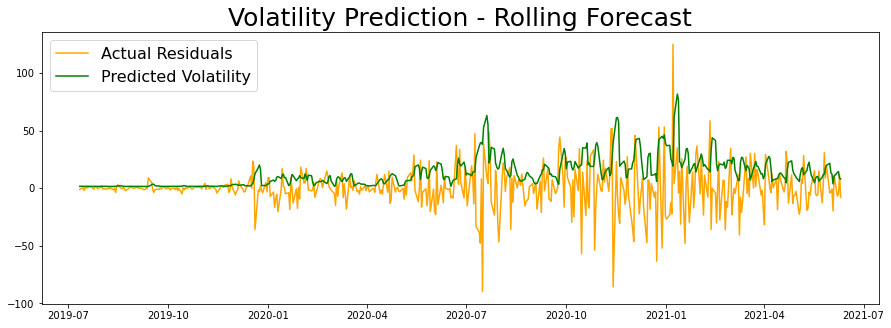

In [56]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 4 Model

In [67]:
model_14 = arch_model(resid_df,p=4,q=0)
model_fit_14 = model_14.fit(disp='off')
model_fit_14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3544.62
Distribution:                  Normal   AIC:                           7101.25
Method:            Maximum Likelihood   BIC:                           7132.07
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        11:30:26   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0757  7.075e-02      1.071      0.284 [-6.293e-02,  0.214]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.6136      0.337      4.791  1.664e-06   [  0.953,  2.274]
alpha[1]       0.2503  5.718e-02      4.378  1.200e-05   [  0.138,  0.362]
alpha[2]       0.2454  4.788e-02      5.126  2.958e-07   [  0.152,  0.339]
alpha[3]       0.2039  5.426e-02      3.757  1.719e-04 [9.751e-02,  0.310]
alpha[4]       0.3004  8.319e-02      3.611  3.052e-04   [  0.137,  0.463]
==========================================================================

Covariance estimator: robust
"""

In [68]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=4, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

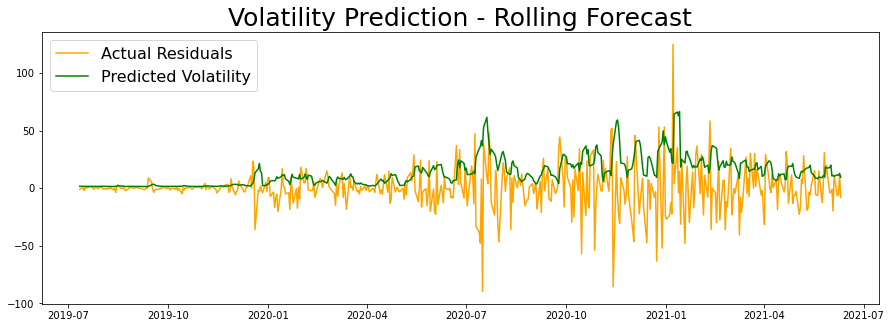

In [69]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 5 Model

In [70]:
model_15 = arch_model(resid_df,p=5,q=0)
model_fit_15 = model_15.fit(disp='off')
model_fit_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3508.56
Distribution:                  Normal   AIC:                           7031.13
Method:            Maximum Likelihood   BIC:                           7067.09
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        11:34:40   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0585  7.051e-02      0.830      0.407 [-7.970e-02,  0.197]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.4859      0.350      4.243  2.210e-05   [  0.799,  2.172]
alpha[1]       0.1865  4.605e-02      4.049  5.149e-05 [9.619e-02,  0.277]
alpha[2]       0.2200  5.265e-02      4.179  2.927e-05   [  0.117,  0.323]
alpha[3]       0.1687  5.558e-02      3.035  2.406e-03 [5.975e-02,  0.278]
alpha[4]       0.2743  8.322e-02      3.296  9.814e-04   [  0.111,  0.437]
alpha[5]       0.1505  4.624e-02      3.256  1.131e-03 [5.991e-02,  0.241]
==========================================================================

Covariance estimator: robust
"""

In [71]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=5, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

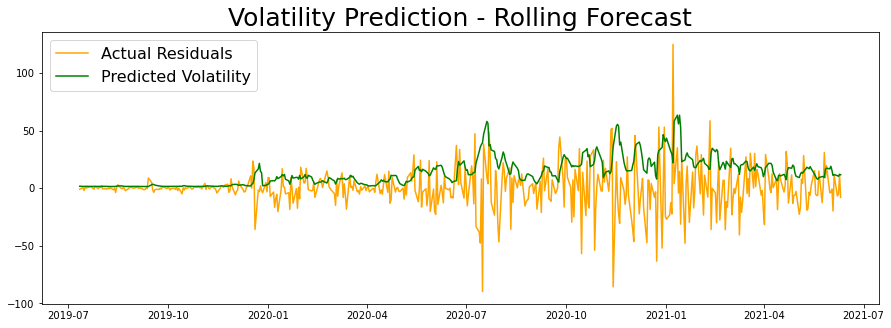

In [72]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 6 Model

In [73]:
model_16 = arch_model(resid_df,p=6,q=0)
model_fit_16 = model_16.fit(disp='off')
model_fit_16.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3494.30
Distribution:                  Normal   AIC:                           7004.61
Method:            Maximum Likelihood   BIC:                           7045.70
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        11:37:49   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0467  7.278e-02      0.641      0.521 [-9.597e-02,  0.189]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.4644      0.355      4.122  3.754e-05   [  0.768,  2.161]
alpha[1]       0.1789  4.525e-02      3.953  7.706e-05 [9.020e-02,  0.268]
alpha[2]       0.2326  5.806e-02      4.006  6.170e-05   [  0.119,  0.346]
alpha[3]       0.1516  5.770e-02      2.627  8.609e-03 [3.850e-02,  0.265]
alpha[4]       0.2226  9.890e-02      2.251  2.440e-02 [2.876e-02,  0.416]
alpha[5]       0.0988  4.757e-02      2.077  3.777e-02 [5.584e-03,  0.192]
alpha[6]       0.1155  5.453e-02      2.118  3.418e-02 [8.615e-03,  0.222]
==========================================================================

Covariance estimator: robust
"""

In [74]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=6, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

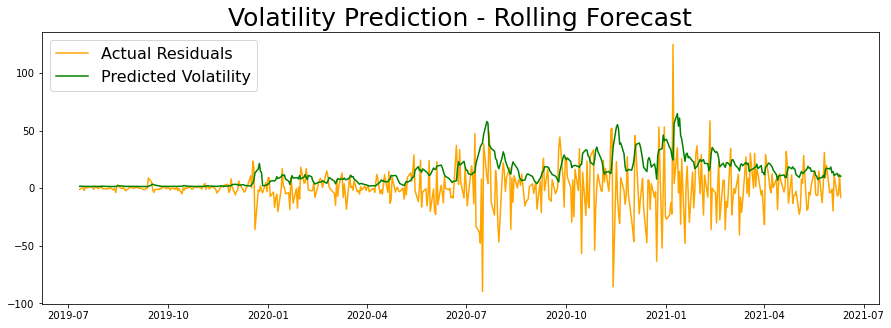

In [75]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 7 Model

In [76]:
model_17 = arch_model(resid_df,p=7,q=0)
model_fit_17 = model_17.fit(disp='off')
model_fit_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3462.98
Distribution:                  Normal   AIC:                           6943.97
Method:            Maximum Likelihood   BIC:                           6990.20
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        11:54:54   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0441  7.130e-02      0.618      0.537 [-9.568e-02,  0.184]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.3511      0.348      3.879  1.047e-04    [  0.668,  2.034]
alpha[1]       0.1683  4.236e-02      3.973  7.106e-05  [8.526e-02,  0.251]
alpha[2]       0.2092  5.503e-02      3.801  1.438e-04    [  0.101,  0.317]
alpha[3]       0.1511  5.861e-02      2.579  9.922e-03  [3.625e-02,  0.266]
alpha[4]       0.1472  8.105e-02      1.817  6.926e-02 [-1.161e-02,  0.306]
alpha[5]       0.0695  5.383e-02      1.290      0.197 [-3.605e-02,  0.175]
alpha[6]       0.1052  5.827e-02      1.806  7.092e-02 [-8.973e-03,  0.219]
alpha[7]       0.1495  5.044e-02      2.963  3.046e-03  [5.059e-02,  0.248]
===========================================================================

Covariance estimator: robust
"""

In [77]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=7, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

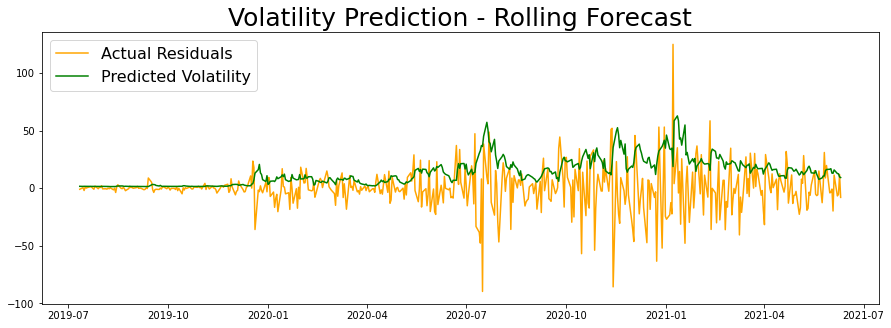

In [78]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 8 Model

In [79]:
model_17 = arch_model(resid_df,p=8,q=0)
model_fit_17 = model_17.fit(disp='off')
model_fit_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3452.13
Distribution:                  Normal   AIC:                           6924.26
Method:            Maximum Likelihood   BIC:                           6975.63
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        11:57:19   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0293  6.563e-02      0.447      0.655 [-9.931e-02,  0.158]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.2791      0.324      3.949  7.841e-05    [  0.644,  1.914]
alpha[1]       0.1657  4.087e-02      4.055  5.010e-05  [8.563e-02,  0.246]
alpha[2]       0.2065  5.550e-02      3.720  1.988e-04  [9.772e-02,  0.315]
alpha[3]       0.1301  5.181e-02      2.511  1.204e-02  [2.855e-02,  0.232]
alpha[4]       0.1331  9.493e-02      1.402      0.161 [-5.294e-02,  0.319]
alpha[5]       0.0612  5.304e-02      1.154      0.248 [-4.274e-02,  0.165]
alpha[6]       0.0620  4.639e-02      1.336      0.181 [-2.893e-02,  0.153]
alpha[7]       0.1089  4.905e-02      2.221  2.635e-02  [1.281e-02,  0.205]
alpha[8]       0.1324  7.226e-02      1.832  6.689e-02 [-9.218e-03,  0.274]
===========================================================================

Covariance estimator: robust
"""

In [81]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=8, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

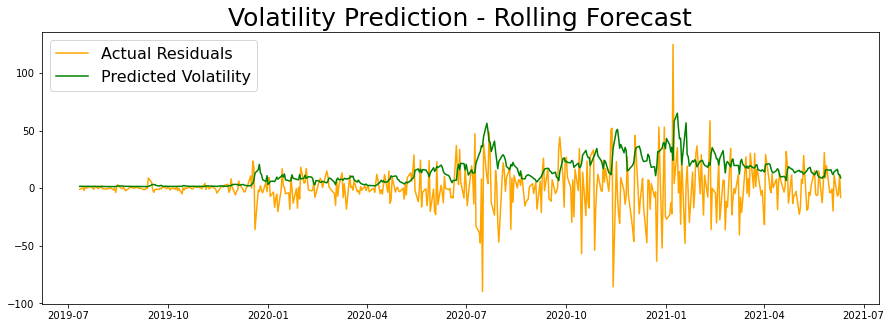

In [82]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

##### ARCH - 9 Model

In [85]:
model_18 = arch_model(resid_df,p=9,q=0)
model_fit_18 = model_18.fit(disp='off')
model_fit_18.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3443.20
Distribution:                  Normal   AIC:                           6908.41
Method:            Maximum Likelihood   BIC:                           6964.92
                                        No. Observations:                 1258
Date:                Sat, Mar 26 2022   Df Residuals:                     1257
Time:                        12:03:25   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0269  6.327e-02      0.425      0.671 [-9.709e-02,  0.151]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.1617      0.316      3.672  2.404e-04      [  0.542,  1.782]
alpha[1]       0.1488  3.864e-02      3.851  1.174e-04    [7.309e-02,  0.225]
alpha[2]       0.2031  5.558e-02      3.654  2.585e-04    [9.413e-02,  0.312]
alpha[3]       0.1272  4.866e-02      2.613  8.965e-03    [3.180e-02,  0.223]
alpha[4]       0.0695  7.883e-02      0.882      0.378   [-8.498e-02,  0.224]
alpha[5]       0.0680  5.161e-02      1.318      0.188   [-3.315e-02,  0.169]
alpha[6]       0.0122  4.039e-02      0.301      0.763 [-6.698e-02,9.133e-02]
alpha[7]       0.1084  4.977e-02      2.178  2.944e-02    [1.083e-02,  0.206]
alpha[8]       0.1388  7.271e-02      1.909  5.621e-02   [-3.677e-03,  0.281]
alpha[9]       0.1240  6.855e-02      1.810  7.037e-02   [-1.031e-02,  0.258]
=============================================================================

Covariance estimator: robust
"""

In [86]:
rolling_predictions = []
test_size = 500

for i in range(test_size):
    train = resid_df[:-(test_size-i)]
    model = arch_model(train, p=9, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=resid_df.index[-test_size:])

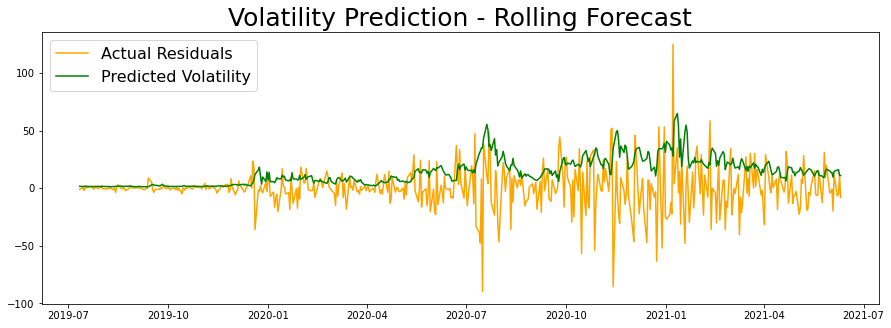

In [87]:
plt.figure(figsize=(15,5))
true, = plt.plot(resid_df[-test_size:],'orange')
preds, = plt.plot(rolling_predictions,'green')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=25)
plt.legend(['Actual Residuals', 'Predicted Volatility'], fontsize=16)
plt.show()

# Future Predictions

##### ARCH - 1 Prediction

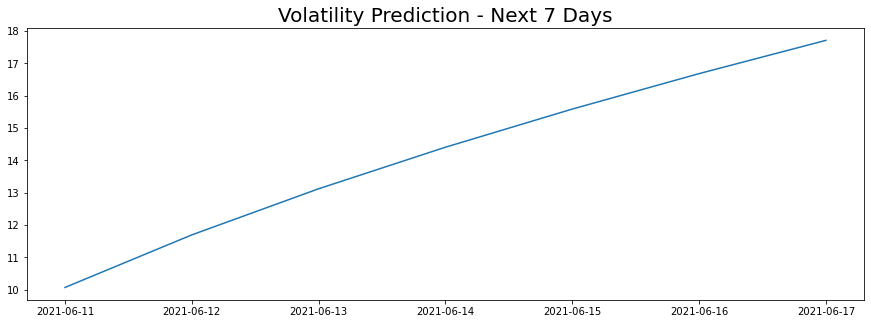

In [110]:
final_df = resid_df
final_model = arch_model(final_df_2, p=1, q=0)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### ARCH - 2 Prediction

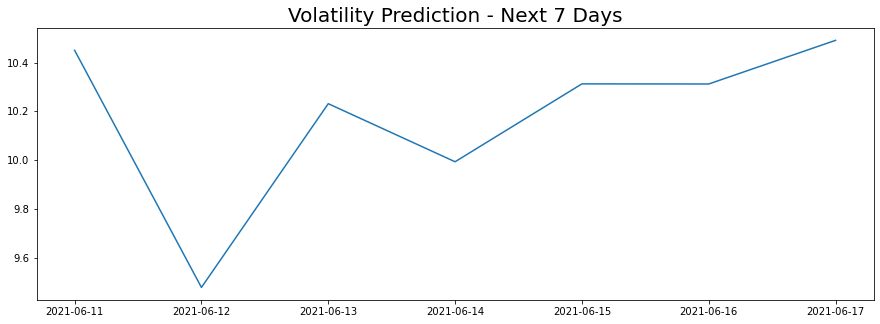

In [111]:
final_df = resid_df
final_model = arch_model(final_df, p=2, q=0)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### ARCH - 3 Prediction

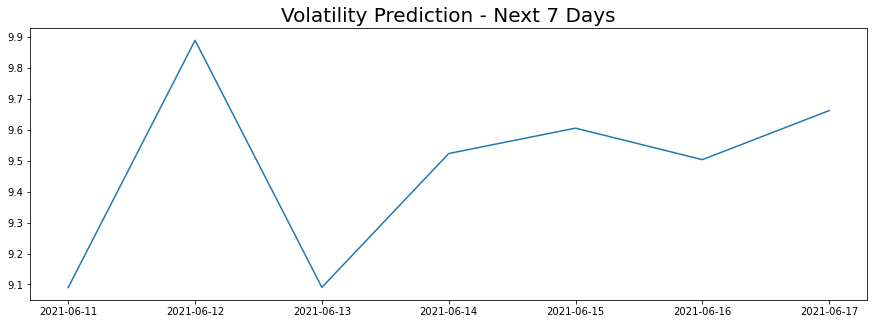

In [112]:
final_df = resid_df
final_model = arch_model(final_df, p=3, q=0)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### ARCH - 4 Prediction

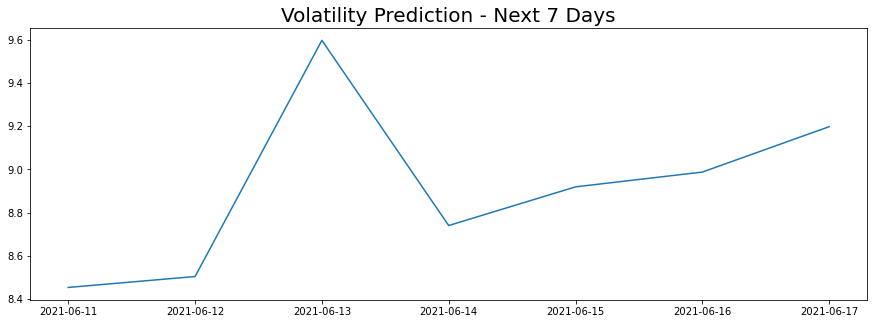

In [113]:
final_df = resid_df
final_model = arch_model(final_df, p=4, q=0)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### ARCH - 5 Prediction

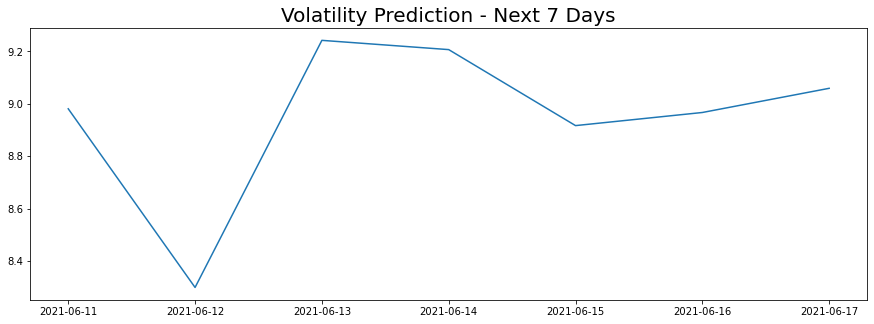

In [114]:
final_df = resid_df
final_model = arch_model(final_df, p=5, q=0)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### ARCH - 6 Prediction

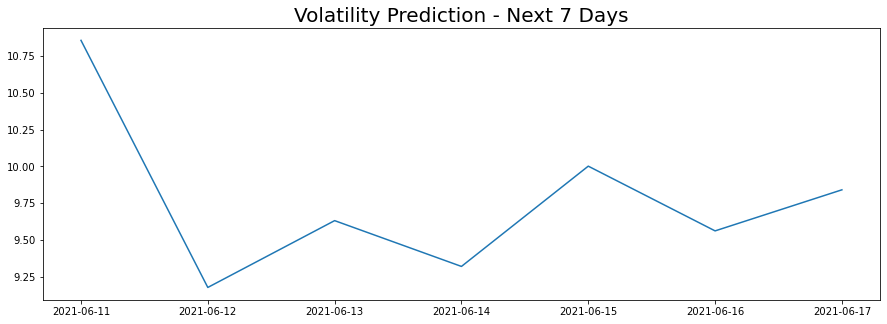

In [115]:
final_df = resid_df
final_model = arch_model(final_df, p=6, q=0)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### GARCH (1,1) prediction

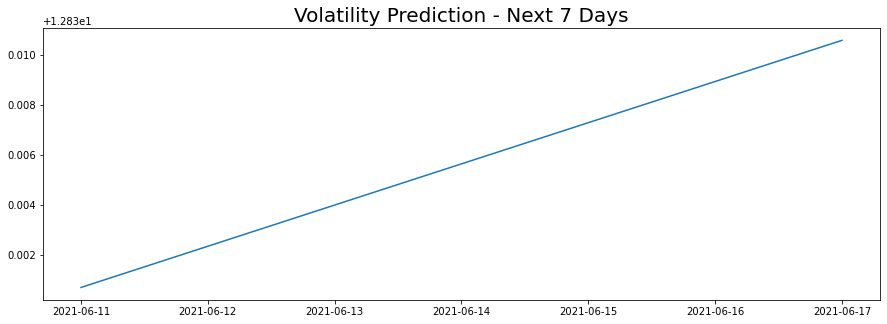

In [116]:
final_df = resid_df
final_model = arch_model(final_df, p=1, q=1)
final_model_fit = final_model.fit(disp='off')

final_pred = final_model_fit.forecast(horizon=7)
future_dates = [resid_df.index[-1] + timedelta(days=i) for i in range(1,8)]
final_pred = pd.Series(np.sqrt(final_pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(15,5))
plt.plot(final_pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()

##### Conclusion:

- Based on the significance of the model parameters and the AIC Score, we can conclude that the ARCH - 6 Model is the best fit model and the future predictions can be done using this model.